In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import math

In [17]:
device = 'cuda'
batch_size = 256

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=32,
                          padding=4,       
                          padding_mode='reflect'),
    transforms.RandAugment(num_ops=2, magnitude=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, pin_memory=True, num_workers=3)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2,
                                         shuffle=False, pin_memory=True, num_workers=3)

Files already downloaded and verified
Files already downloaded and verified


# Triple Attention

In [18]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU(True) if relu else None
        
    def forward(self, x):
        out = self.conv(x)
        if self.bn is not None:
            out = self.bn(out)
        if self.relu is not None:
            out = self.relu(out)
        return out
    
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat(
            (torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1
        )
    
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(
            2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False
        )
    
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid_(x_out)
        return x * scale
    
class TripleAttention(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=["avg", "max"], no_spatial=False):
        super(TripleAttention, self).__init__()
        self.ChannelGate_H = SpatialGate()
        self.ChannelGate_W = SpatialGate()
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_perm1 = x.permute(0, 2, 1, 3).contiguous()
        out_CW = self.ChannelGate_H(x_perm1)
        out_CW = out_CW.permute(0, 2, 1, 3).contiguous()

        x_perm2 = x.permute(0, 3, 2, 1).contiguous()
        out_CH = self.ChannelGate_W(x_perm2)
        out_CH = out_CH.permute(0, 3, 2, 1).contiguous()
        if not self.no_spatial:
            out = self.SpatialGate(x)
            out = (1/3) * (out + out_CW + out_CH)
        else:
            out = (1/2) * (out_CW + out_CH)
        return out

# Coordinate Attention

In [19]:
class CA_Act(nn.Module):
    def __init__(self):
        super(CA_Act, self).__init__()
        self.relu = nn.ReLU6(True)
        
    def forward(self, x):
        out = self.relu(x + 3) / 6
        return x * out
    
class CA_Layer(nn.Module):
    def __init__(self, in_channel, out_channel, stride, i):
        super(CA_Layer, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        
        middle_channel = max(8, in_channel//32)

        self.conv1 = nn.Conv2d(in_channel, middle_channel, kernel_size=3, stride=stride,
                               padding=i+1, dilation=i+1, bias=False)
        self.bn1 = nn.BatchNorm2d(middle_channel)
        self.convh = nn.Conv2d(middle_channel, out_channel, kernel_size=1, stride=1, padding=0)
        self.convw = nn.Conv2d(middle_channel, out_channel, kernel_size=1, stride=1, padding=0)
        self.relu = CA_Act()
        
    def forward(self, x):
        identity = x
        n, c, h, w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)
        
        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.relu(y)
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)
        
        x_h = self.convh(x_h).sigmoid()
        x_w = self.convw(x_w).sigmoid()
        x_h = x_h.expand(-1, -1, h, w)
        x_w = x_w.expand(-1, -1, h, w)
        
        out = identity * x_w * x_h
        return out

In [20]:
class Dense_Layer(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
#         middle_channel = 4 * growth_rate
        growth_rate = in_channel // 2
        
        self.conv1 = nn.Conv2d(in_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(growth_rate)
        self.relu = nn.ReLU(True)
        
#         self.triplet_attention = TripleAttention(middle_channel)
#         self.coordinate_attention = CA_Layer(middle_channel, middle_channel)
    
    def forward(self, x):
#         out = self.triplet_attention(out)
#         out = self.coordinate_attention(out)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        return torch.cat([x, out], 1) # cat on dim 1

# SK-Net

In [21]:
class SKConv(nn.Module):
    def __init__(self, features, M=2, G=32, r=16, stride=1, L=32, growth_rate=16):
        super(SKConv, self).__init__()
        
        d = max(int(features/r), L)
        self.M = M
        self.features = features
        
        self.convs = nn.ModuleList([])
        for i in range(M):
            self.convs.append(nn.Sequential(
                nn.Conv2d(features, features, kernel_size=3, stride=stride,
                          padding=1+i, dilation=1+i, groups=G, bias=False),
                nn.BatchNorm2d(features),
                nn.ReLU(True)
            ))
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Conv2d(features, d, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(d),
            nn.ReLU(True)
        )
        self.fcs = nn.ModuleList([])
        for i in range(M):
            self.fcs.append(
                nn.Conv2d(d, features, kernel_size=1, stride=1)
            )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        feats = [conv(x) for conv in self.convs]
        feats = torch.cat(feats, dim=1)
        feats = feats.view(batch_size, self.M, self.features, feats.shape[2], feats.shape[3])
        
        feats_U = torch.sum(feats, dim=1)
        feats_S = self.gap(feats_U)
        feats_Z = self.fc(feats_S)
        
        attention = [fc(feats_Z) for fc in self.fcs]
        attention = torch.cat(attention, dim=1)
        attention = attention.view(batch_size, self.M, self.features, 1, 1)
        attention = self.softmax(attention)
        
        feats_V = torch.sum(feats * attention, dim=1)
        return feats_V
    
    
class SKUnit(nn.Module):
    def __init__(self, in_features, middle_features, out_features, M=2, G=32, r=16, stride=1, L=32):
        super(SKUnit, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, middle_features, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(middle_features),
            nn.ReLU(True)
        )
        self.conv2_sk = SKConv(middle_features, M, G, r, stride, L)
        self.dense_layer = Dense_Layer(middle_features)
        self.conv3 = nn.Sequential(
            nn.Conv2d(middle_features+middle_features//2, out_features, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_features)
        )
        
        if in_features == out_features:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_features, out_features, 1, stride, bias=False),
                nn.BatchNorm2d(out_features)
            )
        
        self.relu = nn.ReLU(True)
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2_sk(out)
        out = self.dense_layer(out)
        out = self.conv3(out)
        out = out + self.shortcut(identity)
        out = self.relu(out)
        return out
    
class SKNet(nn.Module):
    def __init__(self, num_classes, block_config, strides_list=[1, 2, 2, 2]):
        super(SKNet, self).__init__()
        self.basic_conv = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        
        self.stage_1 = self.make_layer(64, 128, 256, num_blocks=block_config[0], stride=strides_list[0])
        self.stage_2 = self.make_layer(256, 256, 384, num_blocks=block_config[1], stride=strides_list[1])
        self.stage_3 = self.make_layer(384, 384, 512, num_blocks=block_config[2], stride=strides_list[2])
        self.stage_4 = self.make_layer(512, 512, 1024, num_blocks=block_config[3], stride=strides_list[3])
        
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(1024, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def make_layer(self, in_features, middle_features, out_features, num_blocks, stride=1):
        layers = [SKUnit(in_features, middle_features, out_features, stride)]
        for _ in range(1, num_blocks):
            layers.append(SKUnit(out_features, middle_features, out_features))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.basic_conv(x)
        out = self.maxpool(out)
        out = self.stage_1(out)
        out = self.stage_2(out)
        out = self.stage_3(out)
        out = self.stage_4(out)
        out = self.gap(out)
        out = torch.squeeze(out)
        out = self.classifier(out)
        return out

def SKNet26(num_classes=100):
    return SKNet(num_classes, [2,2,2,2])

def SKNet50(num_classes=100):
    return SKNet(num_classes, [3,4,6,3])

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def adjust_learning_rate(optimizer, current_iter, warmup_iter, max_warm_up_lr):
    if current_iter <= warmup_iter:
        lr = max_warm_up_lr * current_iter / warmup_iter
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [23]:
loss_arr = []
top1_acc_arr = []
top5_acc_arr = []
lr_arr = []

def fit(model, epochs, train_loader, valid_loader, optimizer, lr_scheduler,
        loss_fn, updata_lr_every_epoch, warm_up=False, max_warm_up_lr=0.01, grad_clip=None, PATH='./SKNet.pth'):
    log_interval = int((50000/batch_size)/2)
    for epoch in range(epochs):
        print(f"{'='*20} Epoch: {epoch+1} {'='*20}\n")
        model.train()
        avg_loss = 0
        
        for i, (inputs, targets) in enumerate(train_loader):
            if warm_up != False and epoch <= warm_up:
                adjust_learning_rate(optimizer, (i+1)+epoch*len(train_loader), len(train_loader)*warm_up, max_warm_up_lr=max_warm_up_lr)
                lr_arr.append(get_lr(optimizer))
            outputs = model(inputs.to(device))
            loss = loss_fn(outputs, targets.to(device))
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            if lr_scheduler is not None and updata_lr_every_epoch == False:
                lr_scheduler.step()
                lr_arr.append(get_lr(optimizer))
            optimizer.zero_grad()
            
            avg_loss += loss.item()
            if i % log_interval == log_interval-1:
                avg_loss = avg_loss/log_interval
                print(f"batch: {i+1}, train_loss: {avg_loss:.4f}")
                avg_loss = 0
                
        if lr_scheduler is not None and updata_lr_every_epoch == True:
            lr_scheduler.step()
            lr_arr.append(get_lr(optimizer))
        if lr_scheduler is None:
            lr_arr.append(get_lr(optimizer))
        
        model.eval()
        top1_correct = 0
        top5_correct = 0
        total = 0
        avg_loss = 0
        with torch.no_grad():
            for (images, labels) in valid_loader:
                labels = labels.to(device)
                outputs = model(images.to(device))
                _, predicted = torch.topk(outputs.data, 5, dim=1, largest=True, sorted=True)
                total += labels.cpu().size(0)
                top1_correct += (predicted[:, 0] == labels).sum().item()
                for i in range(len(labels)):
                    if labels[i] in predicted[i]:
                        top5_correct += 1
                avg_loss += loss_fn(outputs, labels)
            avg_loss = avg_loss.cpu() / len(valid_loader)
            loss_arr.append(avg_loss)
            top1_acc = 100 * top1_correct / total
            top5_acc = 100 * top5_correct / total
            top1_acc_arr.append(top1_acc)
            top5_acc_arr.append(top5_acc)
        print(f'Top1 Accuracy: {top1_acc}% ({top1_correct} / {total}), Top5 Accuracy: {top5_acc}% ({top5_correct} / {total}), Loss: {avg_loss:.3f}, Last_lr: {lr_arr[-1]:.5f}')
    torch.save(model, PATH)

In [24]:
model = SKNet26().to(device)
num_param = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fM" % (num_param/1e6))

Number of parameter: 10.09M


In [27]:
%%time
epochs = 30
# optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# sched = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.2)
sched = optim.lr_scheduler.OneCycleLR(optimizer, 0.01, epochs=epochs,
                                      steps_per_epoch=len(trainloader))

fit(model=model,
    epochs=epochs,
    train_loader=trainloader,
    valid_loader=testloader,
    optimizer=optimizer,
    lr_scheduler=sched,
    loss_fn=nn.CrossEntropyLoss(),
    warm_up=False, max_warm_up_lr=0.01,
    grad_clip=None, updata_lr_every_epoch=False, PATH='./SKNet.pth')

==================== Epoch: 1 ====================



KeyboardInterrupt: 

Text(0.5, 1.0, 'LR')

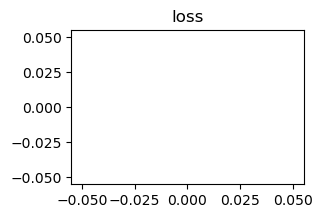

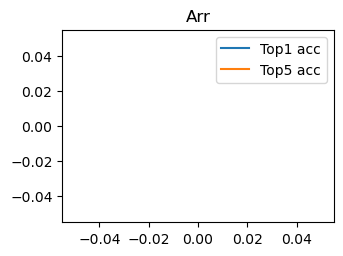

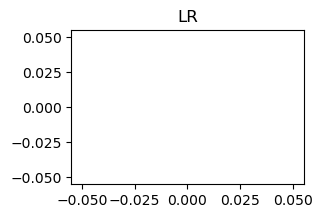

In [26]:
plt.figure(figsize=(3, 2))
plt.plot(loss_arr)
plt.title('loss')

plt.figure(figsize=(3.5, 2.5))
plt.plot(top1_acc_arr)
plt.plot(top5_acc_arr)
plt.legend(['Top1 acc','Top5 acc'])
plt.title('Arr')

plt.figure(figsize=(3, 2))
plt.plot(lr_arr)
plt.title('LR')